In [3]:
# ===== alpha_sweep_w2v.py —— 多个 α 训练 + 评估 + 画图（Jupyter友好；零参数） =====
import os, time, math
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec, KeyedVectors

# --------- 超参与路径 ---------
TEXT8 = Path("data/text8")
assert TEXT8.exists(), "缺少 data/text8，请先准备语料。"

N = 20
OUT = Path("outputs"); OUT.mkdir(exist_ok=True)
ALPHAS = [round(x, 3) for x in np.linspace(0.5, 1.0, N)]   # ← 想测哪些 α（ns_exponent）
VECTOR_SIZE = 300
WINDOW = 5
NEGATIVE = 10
SAMPLE = 1e-3
MIN_COUNT = 5
EPOCHS = 5
SEED = 42

# --------- 数据处理：把 text8 切成“伪句子”块，便于迭代 ---------
def read_text8(path: Path, chunk=10_000):
    with open(path, "r", encoding="utf-8") as f:
        toks = f.read().strip().split()
    n = len(toks)
    for i in range(0, n, chunk):
        yield toks[i:i+chunk]

SENTS = list(read_text8(TEXT8))

# --------- 评测函数（与之前 eval_suite 同源的核心 3 指标）---------
def l2_normalize(mat, eps=1e-9):
    nrm = np.linalg.norm(mat, axis=1, keepdims=True) + eps
    return mat / nrm

def cosine_matrix(A, B):
    return A @ B.T  # A/B 需先单位化

def knn_coherence(W, sample_size=1000, k=10, seed=42):
    rng = np.random.default_rng(seed)
    V = W.shape[0]
    idx = rng.choice(V, size=min(sample_size, V), replace=False)
    X = l2_normalize(W[idx])
    S = cosine_matrix(X, X)
    np.fill_diagonal(S, -np.inf)
    part = np.partition(S, -k, axis=1)[:, -k:]
    return float(part.mean())

def hubness(W, sample_size=2000, k=10, seed=42):
    rng = np.random.default_rng(seed)
    V = W.shape[0]
    idx = rng.choice(V, size=min(sample_size, V), replace=False)
    X = l2_normalize(W[idx])
    S = cosine_matrix(X, X)
    np.fill_diagonal(S, -np.inf)
    topk_idx = np.argpartition(S, -k, axis=1)[:, -k:]
    counts = np.bincount(topk_idx.reshape(-1), minlength=X.shape[0]).astype(np.float64)
    c = counts / max(counts.sum(), 1.0)
    mu = c.mean(); sd = c.std() + 1e-12
    skew = (((c - mu)**3).mean()) / (sd**3)
    sorted_c = np.sort(c); n = len(sorted_c)
    gini = 1 - 2 * np.sum((n - np.arange(1, n+1) + 0.5) * sorted_c) / (n * sorted_c.sum() + 1e-12)
    return {"skew": float(skew), "gini": float(gini)}

def isotropy(W):
    X = l2_normalize(W)
    m = X.mean(axis=0)
    iso = 1.0 - float(np.linalg.norm(m))
    return max(0.0, min(1.0, iso))

def load_vec(vec_path):
    # 优先用 gensim 读 .vec
    wv = KeyedVectors.load_word2vec_format(vec_path, binary=False)
    vocab = wv.index_to_key
    W = np.stack([wv[w] for w in vocab], axis=0)
    return vocab, W

# --------- 训练或跳过（若已有同名文件）---------
def train_or_skip(alpha):
    model_path = OUT / f"w2v_text8_alpha{alpha:.3f}.model"  
    vec_path   = OUT / f"w2v_text8_alpha{alpha:.3f}.vec"
    if vec_path.exists():
        print(f"[skip] alpha={alpha} 已存在：{vec_path.name}")
        return str(vec_path)
    print(f"[train] alpha={alpha} | ns_exponent={alpha}")
    t0 = time.time()
    model = Word2Vec(
        sentences=SENTS,
        vector_size=VECTOR_SIZE,
        window=WINDOW,
        sg=1,
        negative=NEGATIVE,
        ns_exponent=alpha,     # ★ 关键：负采样幂指数 α
        sample=SAMPLE,
        min_count=MIN_COUNT,
        workers=os.cpu_count() and max(1, os.cpu_count()-1) or 1,
        epochs=EPOCHS,
        seed=SEED
    )
    dt = time.time() - t0
    model.save(str(model_path))
    model.wv.save_word2vec_format(str(vec_path), binary=False)
    print(f"  → done in {dt/60:.1f} min | 保存 {vec_path.name}")
    return str(vec_path)

# --------- 主循环：训练 + 评测 ---------
records = []
for a in ALPHAS:
    vec = train_or_skip(a)
    vocab, W = load_vec(vec)
    coh = knn_coherence(W, sample_size=1000, k=10)
    hub = hubness(W, sample_size=2000, k=10)
    iso = isotropy(W)
    rec = {"alpha": a, "coh": coh, "gini": hub["gini"], "skew": hub["skew"], "iso": iso}
    records.append(rec)
    print(f"[eval] α={a:.2f} | coh@10={coh:.4f} | gini={hub['gini']:.4f} | skew={hub['skew']:.4f} | iso={iso:.4f}")

# --------- 画图：横轴 α，纵轴为多条指标曲线 ---------
# 为了“越高越好”方向一致：使用 (1 - gini) 与 (-skew)
alph = [r["alpha"] for r in records]
coh  = [r["coh"]   for r in records]
iso  = [r["iso"]   for r in records]
gini_inv = [1.0 - r["gini"] for r in records]
skew_inv = [-r["skew"]      for r in records]

plt.figure(figsize=(10,6))
plt.plot(alph, coh, marker='o', label='coherence@10 (↑)')
plt.plot(alph, iso, marker='o', label='isotropy (↑)')
plt.plot(alph, gini_inv, marker='o', label='1 - gini (↑)')
plt.plot(alph, skew_inv, marker='o', label='- skew (↑)')
for x, y in zip(alph, coh):
    plt.annotate(f"{y:.2f}", (x, y), textcoords="offset points", xytext=(0,6), ha='center', fontsize=8)
plt.xlabel("ns_exponent α")
plt.ylabel("score (higher is better)")
plt.title("Word2Vec (SGNS) — α sweep on Text8")
plt.grid(True, alpha=0.3)
plt.legend()
out_fig = OUT / f"alpha_sweep_metrics_{N}.png"
plt.tight_layout(); plt.savefig(out_fig, dpi=200); plt.close()
print(f"\n✅ 已保存对比图：{out_fig}")

# --------- 打印表格摘要 ---------
print("\n=== Summary ===")
print(f"{'alpha':>5s}  {'coh@10':>7s}  {'gini':>6s}  {'skew':>7s}  {'iso':>6s}")
for r in records:
    print(f"{r['alpha']:5.2f}  {r['coh']:7.4f}  {r['gini']:6.3f}  {r['skew']:7.3f}  {r['iso']:6.3f}")


[train] alpha=0.5 | ns_exponent=0.5
  → done in 1.2 min | 保存 w2v_text8_alpha0.500.vec
[eval] α=0.50 | coh@10=0.7464 | gini=0.6217 | skew=2.4008 | iso=0.3217
[train] alpha=0.526 | ns_exponent=0.526
  → done in 1.2 min | 保存 w2v_text8_alpha0.526.vec
[eval] α=0.53 | coh@10=0.7399 | gini=0.6225 | skew=2.3993 | iso=0.3275
[train] alpha=0.553 | ns_exponent=0.553
  → done in 1.2 min | 保存 w2v_text8_alpha0.553.vec
[eval] α=0.55 | coh@10=0.7337 | gini=0.6246 | skew=2.1735 | iso=0.3335
[train] alpha=0.579 | ns_exponent=0.579
  → done in 1.2 min | 保存 w2v_text8_alpha0.579.vec
[eval] α=0.58 | coh@10=0.7284 | gini=0.6206 | skew=2.4469 | iso=0.3394
[train] alpha=0.605 | ns_exponent=0.605
  → done in 1.2 min | 保存 w2v_text8_alpha0.605.vec
[eval] α=0.60 | coh@10=0.7215 | gini=0.6268 | skew=2.3504 | iso=0.3452
[train] alpha=0.632 | ns_exponent=0.632
  → done in 1.2 min | 保存 w2v_text8_alpha0.632.vec
[eval] α=0.63 | coh@10=0.7167 | gini=0.6195 | skew=2.4112 | iso=0.3510
[train] alpha=0.658 | ns_exponent=0.65

Best α by composite = 0.5 | score = 0.529


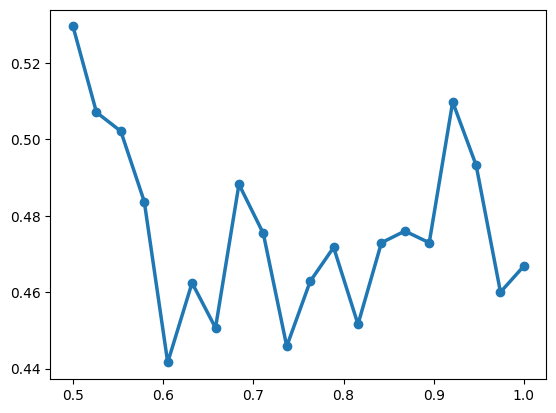

In [4]:
def minmax(xs):
    lo, hi = min(xs), max(xs)
    return [(x-lo)/(hi-lo+1e-12) for x in xs]

coh_n  = minmax(coh)
iso_n  = minmax(iso)
gini_n = minmax(gini_inv)   # 1 - gini
skew_n = minmax(skew_inv)   # - skew

w = dict(coh=0.5, iso=0.3, gini=0.15, skew=0.05)
score = [w["coh"]*c + w["iso"]*i + w["gini"]*g + w["skew"]*s
         for c,i,g,s in zip(coh_n, iso_n, gini_n, skew_n)]

plt.plot(alph, score, marker='o', linewidth=2.5, label='composite (↑)')
best_i = int(np.argmax(score))
print(f"Best α by composite = {alph[best_i]} | score = {score[best_i]:.3f}")
